This code downloads radar data via Amazon Web Services, then creates a 4-panel plot using Py-Art and Cartopy. Code for AWS retrieval is originally from Scott Collis: https://github.com/scollis

In [1]:
##Run this cell first
import warnings
warnings.simplefilter("ignore", DeprecationWarning)
from boto.s3.connection import S3Connection
import cartopy.crs as ccrs
import gzip
from matplotlib import pyplot as plt
import shutil, os
from datetime import timedelta, datetime
import numpy as np
import tempfile
import pyart
def nearestDate(dates, pivot):
    return min(dates, key=lambda x: abs(x - pivot))


def get_radar_from_aws(site, datetime_t):
    """
    Get the closest volume of NEXRAD data to a particular datetime.
    Parameters
    ----------
    site : string
        four letter radar designation 
    datetime_t : datetime
        desired date time
    """
    
    #First create the query string for the bucket knowing
    #how NOAA and AWS store the data
    
    my_pref = datetime_t.strftime('%Y/%m/%d/') + site
    
    #Connect to the bucket
    
    conn = S3Connection(anon = True)
    bucket = conn.get_bucket('noaa-nexrad-level2')
    
    #Get a list of files 
    
    bucket_list = list(bucket.list(prefix = my_pref))
    #print(bucket_list)
    #we are going to create a list of keys and datetimes to allow easy searching
    #print bucket_list
    keys = []
    datetimes = []
    
    #populate the list

    for i in range(len(bucket_list)):
        this_str = str(bucket_list[i].key)
        if 'gz' in this_str:
            endme = this_str[-22:-3]
            fmt = '%Y%m%d_%H%M%S_V06' 
            dt = datetime.strptime(endme, fmt)
            datetimes.append(dt)
            keys.append(bucket_list[i])
            #print(dt)
        if this_str[-3::] == 'V06': #'LSX20160707_000150_' does not match format '%Y%m%d_%H%M%S_V06'
            #print(this_str)
            #print(this_str[-19::])
            endme = this_str[-19::]
            fmt = '%Y%m%d_%H%M%S_V06' 
            dt = datetime.strptime(endme, fmt)
            datetimes.append(dt)
            keys.append(bucket_list[i])
    
    #function to allow easy searching 
    
    def func(x):
        delta =  x - datetime_t if x > datetime_t else timedelta.max
        return delta
    
    #find the closest available radar to your datetime 
    
    closest_datetime = nearestDate(datetimes, datetime_t)
    index = datetimes.index(closest_datetime)
    #print(closest_datetime)
    #create a temp file, download radar data to file from S3
    #read into a radar object and return
    
    localfile = tempfile.NamedTemporaryFile(delete=False)
    keys[index].get_contents_to_filename(localfile.name)
    radar = pyart.io.read(localfile.name)
    name_str = str(bucket_list[index].key)
    return (radar,name_str[-22:-4])


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



C:\ProgramData\Anaconda3\envs\SATPY\lib\site-packages\pyart\graph\cm.py:104: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'red' in spec:
C:\ProgramData\Anaconda3\envs\SATPY\lib\site-packages\pyart\graph\cm_colorblind.py:32: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'red' in spec:
C:\ProgramData\Anaconda3\envs\SATPY\lib\site-packages\heapdict.py:11: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  class heapdict(collections.MutableMapping):


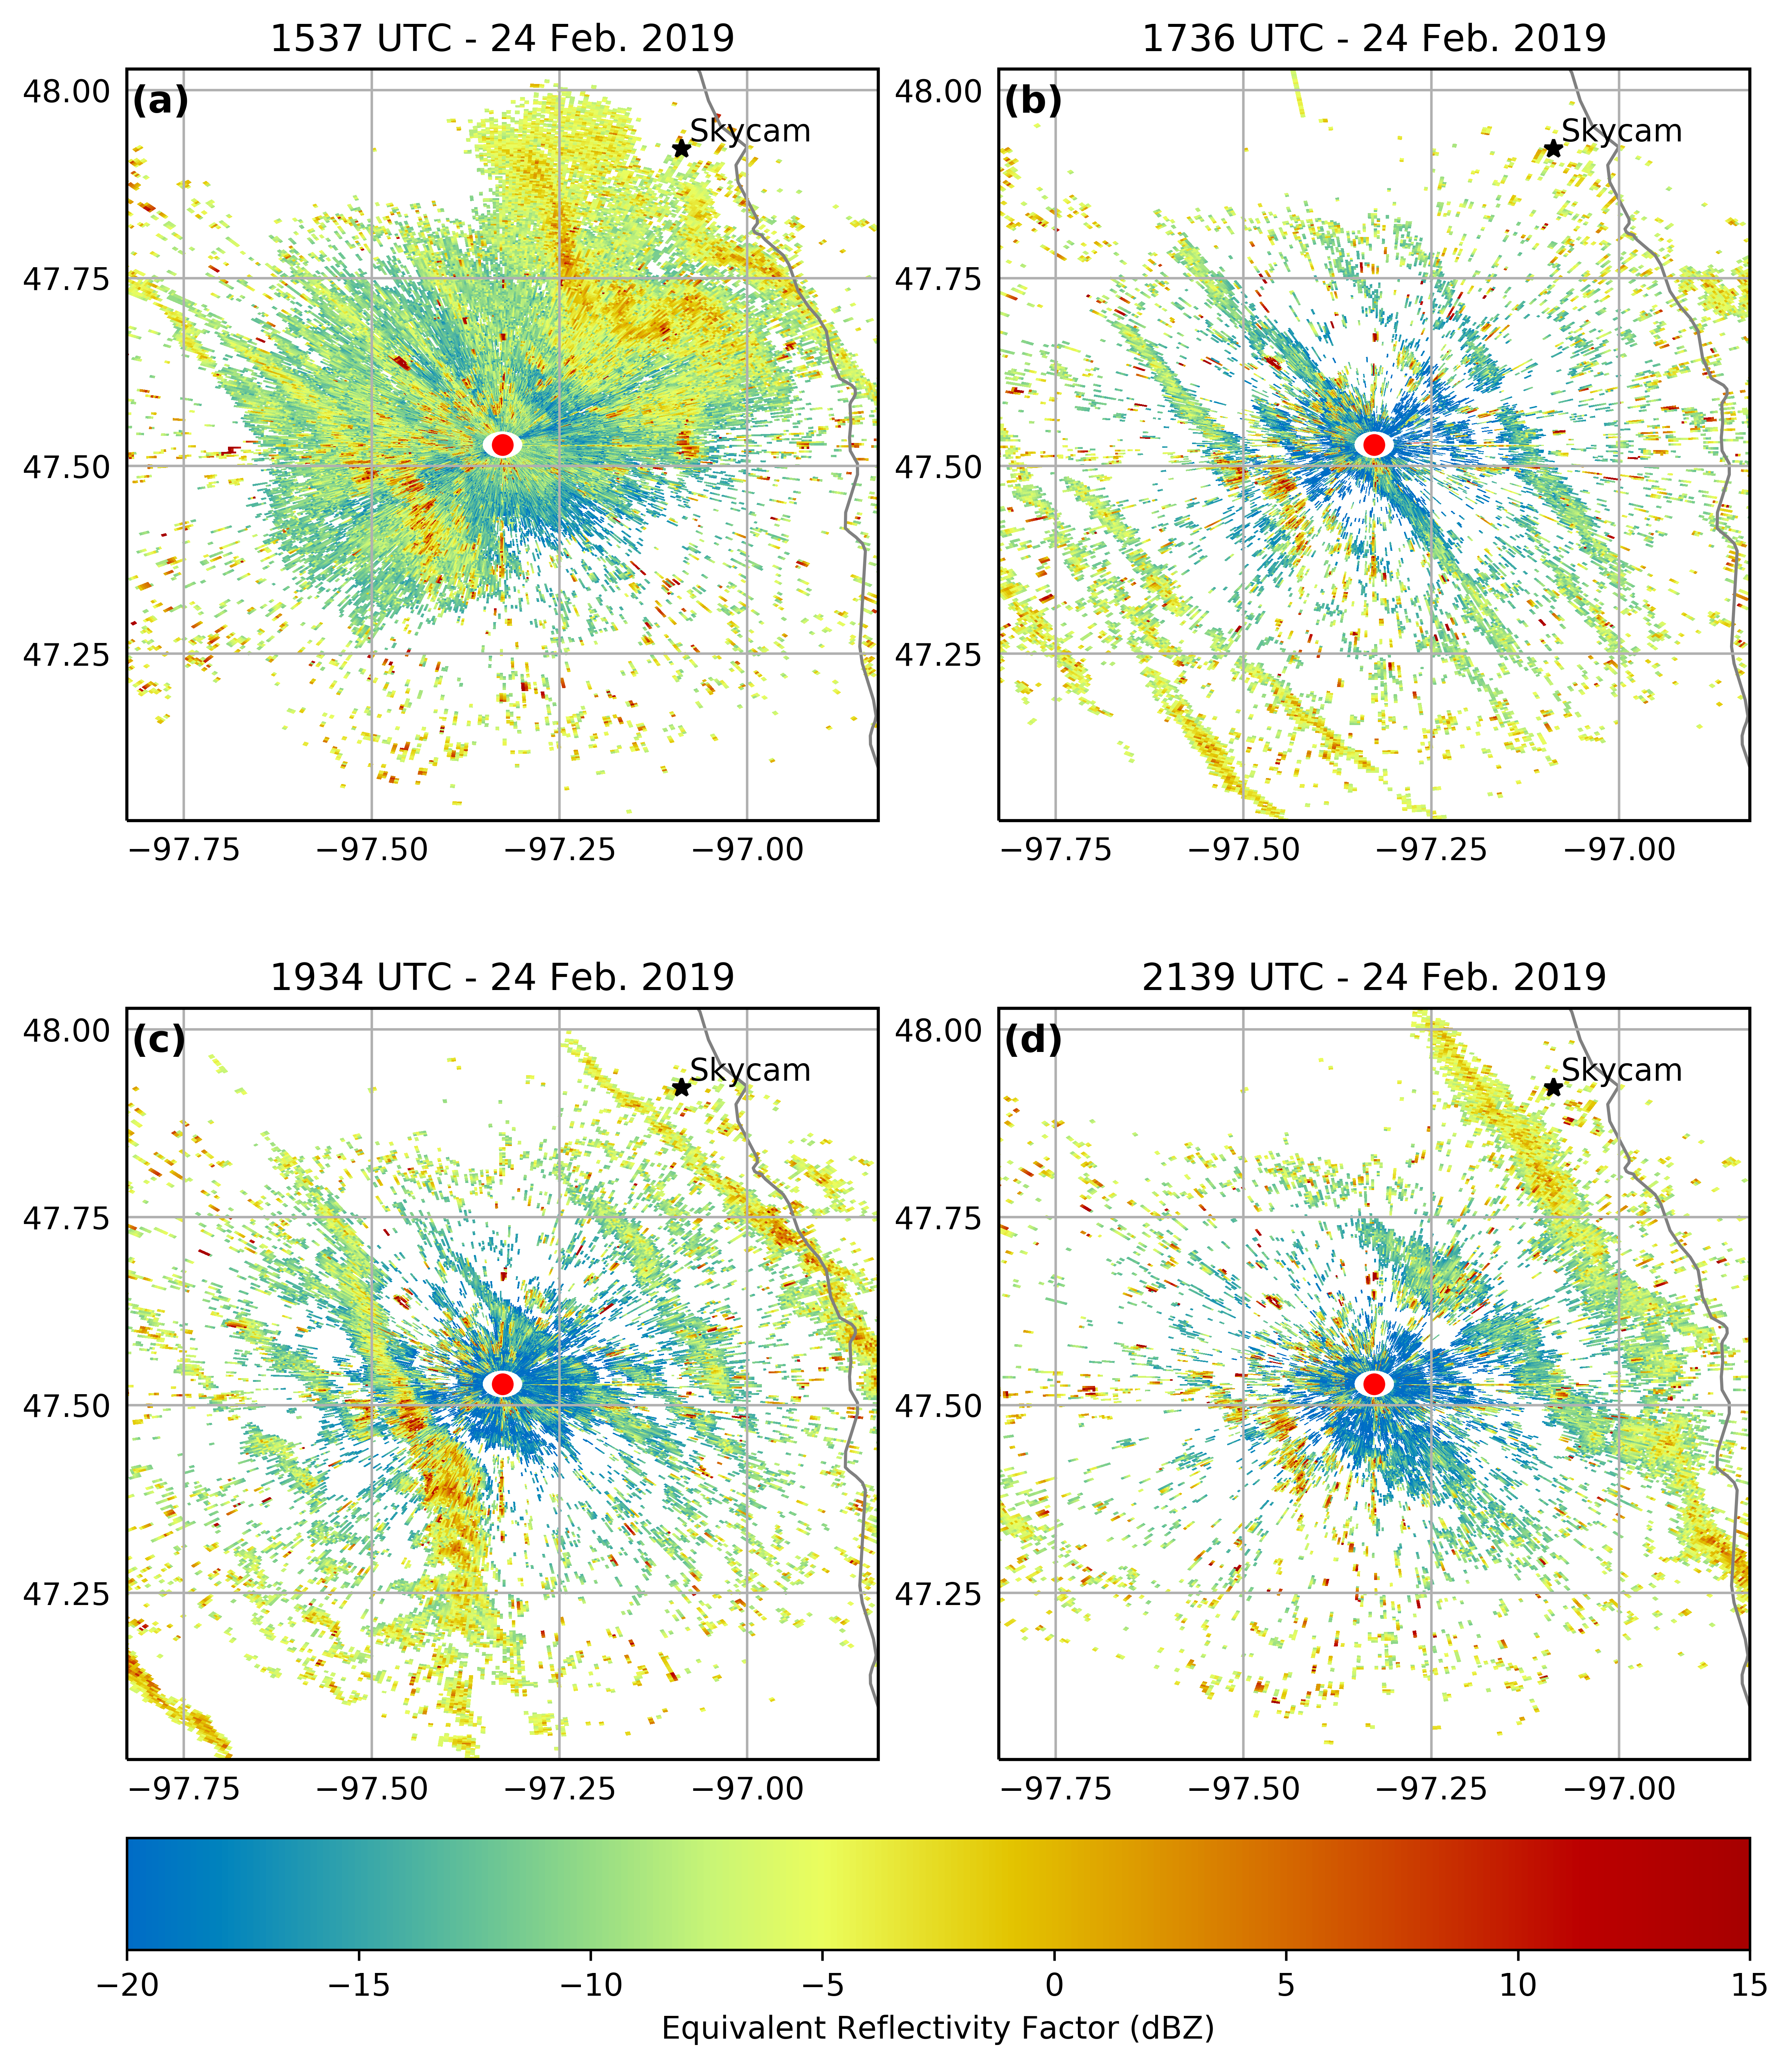

In [2]:
radar_name='KMVX'
b_d = datetime(2019,2,24,15,37) #datetime.utcnow() #datetime.strptime(base_date, fmt)
my_radar15 = get_radar_from_aws(radar_name,b_d)
b_d = datetime(2019,2,24,17,37)
my_radar17 = get_radar_from_aws(radar_name,b_d)
b_d = datetime(2019,2,24,19,37)
my_radar19 = get_radar_from_aws(radar_name,b_d)
b_d = datetime(2019,2,24,21,37)
my_radar21 = get_radar_from_aws(radar_name,b_d)

center_lon=my_radar15[0].longitude['data'][0] #Grab center coordinates of radar
center_lat=my_radar15[0].latitude['data'][0]  #Grab center coordinates of radar

#Define range around center coordinates to plot.  This is in degrees latitude/longitude
min_lat = center_lat-0.5
max_lat = center_lat+0.5
min_lon = center_lon-0.5
max_lon = center_lon+0.5
projection = ccrs.PlateCarree()
lons=[-98,-97.75,-97.5,-97.25,-97,-96.75,-96.5]
lats=[47,47.25,47.5,47.75,48,48.25,48.5]
display = pyart.graph.RadarMapDisplay(my_radar15[0])
fig = plt.figure(figsize=(10, 10),dpi=600)  #Create figure
ax1 = fig.add_subplot(221,projection=projection) 
display.plot_ppi_map('reflectivity', 1, vmin=-20, vmax=15,
                     min_lon=min_lon, max_lon=max_lon, min_lat=min_lat, max_lat=max_lat,
                     resolution='10m', projection=projection,colorbar_flag=0,
                     fig=fig, lat_0=my_radar15[0].latitude['data'][0],
                     lon_0=my_radar15[0].longitude['data'][0],title = '1537 UTC - 24 Feb. 2019',
                     lat_lines=lats, lon_lines=lons)
display.plot_point(center_lon, center_lat)
display.plot_point(-97.08697021,47.92184258,color='black',symbol='*',label_text='Skycam')
ax1.text(-97.82, 47.97, '(a)',fontsize=12, fontweight='bold',transform=projection)

display = pyart.graph.RadarMapDisplay(my_radar17[0])
ax2= fig.add_subplot(222,projection=projection) 
display.plot_ppi_map('reflectivity', 1, vmin=-20, vmax=15,
                     min_lon=min_lon, max_lon=max_lon, min_lat=min_lat, max_lat=max_lat,
                     resolution='10m', projection=projection,colorbar_flag=0,
                     fig=fig, lat_0=center_lat,
                     lon_0=center_lon,title = '1736 UTC - 24 Feb. 2019',
                     lat_lines=lats, lon_lines=lons)
display.plot_point(center_lon, center_lat)
display.plot_point(-97.08697021,47.92184258,color='black',symbol='*',label_text='Skycam')
ax2.text(-97.82, 47.97, '(b)',fontsize=12, fontweight='bold',transform=projection)
display = pyart.graph.RadarMapDisplay(my_radar19[0])
ax3= fig.add_subplot(223,projection=projection) 
display.plot_ppi_map('reflectivity', 1, vmin=-20, vmax=15,
                     min_lon=min_lon, max_lon=max_lon, min_lat=min_lat, max_lat=max_lat,
                     resolution='10m', projection=projection,colorbar_flag=0,
                     fig=fig, lat_0=center_lat,
                     lon_0=center_lon,title = '1934 UTC - 24 Feb. 2019',
                     lat_lines=lats, lon_lines=lons)
display.plot_point(center_lon, center_lat)
display.plot_point(-97.08697021,47.92184258,color='black',symbol='*',label_text='Skycam')
ax3.text(-97.82, 47.97, '(c)',fontsize=12, fontweight='bold',transform=projection)
display = pyart.graph.RadarMapDisplay(my_radar21[0])
ax4= fig.add_subplot(224,projection=projection) 
display.plot_ppi_map('reflectivity', 1, vmin=-20, vmax=15,
                     min_lon=min_lon, max_lon=max_lon, min_lat=min_lat, max_lat=max_lat,
                     resolution='10m', projection=projection,colorbar_flag=0,
                     fig=fig, lat_0=center_lat,
                     lon_0=center_lon,title = '2139 UTC - 24 Feb. 2019',
                     lat_lines=lats, lon_lines=lons)
display.plot_point(center_lon, center_lat)
display.plot_point(-97.08697021,47.92184258,color='black',symbol='*',label_text='Skycam')
ax4.text(-97.82, 47.97, '(d)',fontsize=12, fontweight='bold',transform=projection)
#Setup colorbar
colorbar_panel_axes = [0.15, 0.04, 0.725, 0.05]
cbax = fig.add_axes(colorbar_panel_axes)
display.plot_colorbar(cax=cbax,orient='horizontal', label='Equivalent Reflectivity Factor (dBZ)')

plt.subplots_adjust(hspace = 0.25, wspace = 0.01)
#plt.savefig('KJ_MWR_2020_Fig07_final.png',dpi=300,bbox_inches='tight') #saves file to image
#plt.savefig('KJ_MWR_2020_Fig01_final.pdf',format='pdf',bbox_inches='tight') #saves file to image
plt.show()
